### Prawler Oxygen Analyis 
Correction to oxy profiles

In [1]:
import warnings
#remove the numpy/pandas/cython warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed,")

from erddapy import ERDDAP
import pandas as pd
import numpy as np

server_url = 'http://downdraft.pmel.noaa.gov:8080/erddap'

e = ERDDAP(server=server_url)

df = pd.read_csv(e.get_search_url(response='csv', search_for='PRAWLER'))

print('We have {} tabledap, {} griddap, and {} wms endpoints.'.format(
    len(set(df['tabledap'].dropna())),
    len(set(df['griddap'].dropna())),
    len(set(df['wms'].dropna()))
))

prawlers = df['Dataset ID'].values
print(prawlers)

We have 10 tabledap, 0 griddap, and 0 wms endpoints.
['erddap_4fd3_fb30_b89f' 'erddap_17bsitae_prawler'
 'erddap_17ckitaem2a_prawler' 'erddap_18bsitaepr2a_prawler'
 'erddap_18mtitaepr1a_prawler' 'erddap_19bsitaepr2a_prawler'
 'erddap_17ckitaem2a_met' 'erddap_18bsitaepr2a_met'
 'erddap_18mtitaepr1a_met' 'erddap_19bsitaepr2a_met']


### retrieving and plotting data

In [2]:
d = ERDDAP(server=server_url,
           protocol='tabledap',
           response='csv',
          )

d.dataset_id='erddap_19bsitaepr2a_prawler'

d.variables =  [
 'profile_id',
 'Temperature',
 'Salinity',
 'Chlorophyll',
 'Turbidity',
 'latitude',
 'longitude',
 'depth',
 "time",
 'Oxy_Conc',
 'Oxy_Sat'
]

d.constraints = {
    'time>=': '2018-01-01T00:00:00Z',
    'time<=': '2019-10-10T00:00:00Z',
}

In [3]:
df = d.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
    skiprows=(1,)  # units information can be dropped.
).dropna()

df.head()

,profile_id,Temperature,Salinity (PSU),Chlorophyll,Turbidity,latitude (degrees_north),longitude (degrees_east),depth (m),Oxy_Conc,Oxy_Sat (percent)
time (UTC),,,,,,,,,,
2019-04-24 23:31:37+00:00,1,3.991,31.933832,0.0,0.0,56.873,-164.065,3.17,344.53590,106.924130
2019-04-24 23:31:45+00:00,1,3.897,31.935938,0.0,0.0,56.873,-164.065,3.28,345.39206,106.946976
2019-04-24 23:31:53+00:00,1,3.878,31.935360,0.0,0.0,56.873,-164.065,3.77,346.16818,107.137310
2019-04-24 23:32:01+00:00,1,3.819,31.938852,0.0,0.0,56.873,-164.065,3.44,346.57874,107.113230
2019-04-24 23:32:09+00:00,1,3.898,31.939550,0.0,0.0,56.873,-164.065,3.54,346.03660,107.152070


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker

import cmocean

### specify primary bulk figure parameters
fontsize = 10
labelsize = 10
#plotstyle = 'seaborn'
max_xticks = 10
plt.style.use('seaborn-ticks')
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['ps.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['pdf.fonttype'] = 42 #truetype/type2 fonts instead of type3
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.edgecolor'] = 'black'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['xtick.major.size'] = 4
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.size'] = 4
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.color'] = 'black'

In [5]:
dfsg = df.groupby('profile_id')

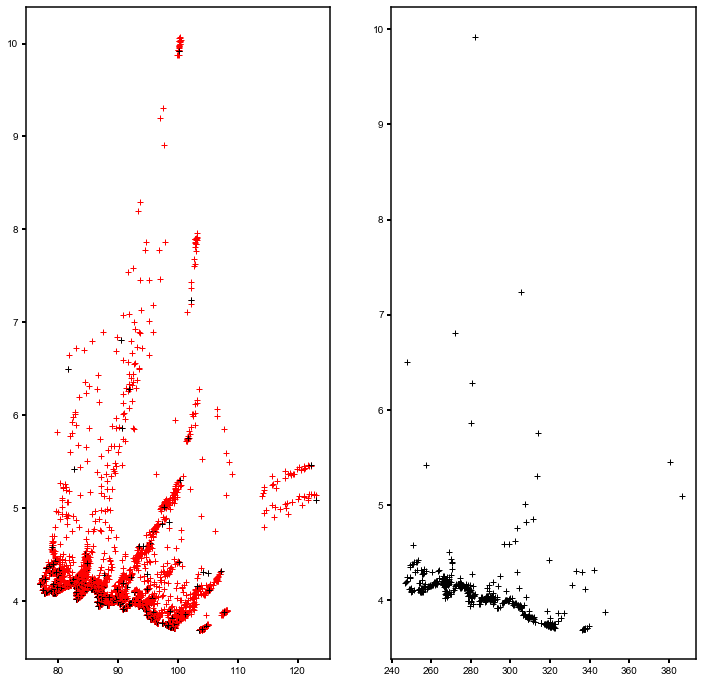

In [71]:
fig, ax = plt.subplots(1,2,figsize=(12, 12))
mld = pd.DataFrame(columns=['MixedLayerDepth','DateTime'])
temp_mld = 0
for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth (m)'].std() > 1:
        temp_mld = dfsg.get_group(cast)['depth (m)'][(dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth (m)'].diff()).idxmin()]
        mld = mld.append({'MixedLayerDepth':temp_mld,
                   'DateTime': (dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth (m)'].diff()).idxmin()},
                   ignore_index=True)
    if (dfsg.get_group(cast)['depth (m)'].std() < 1) and (dfsg.get_group(cast)['depth (m)'].median() > temp_mld) and (temp_mld > 15):
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat (percent)'],dfsg.get_group(cast)['Temperature'],'r+')
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat (percent)'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Oxy_Conc'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        


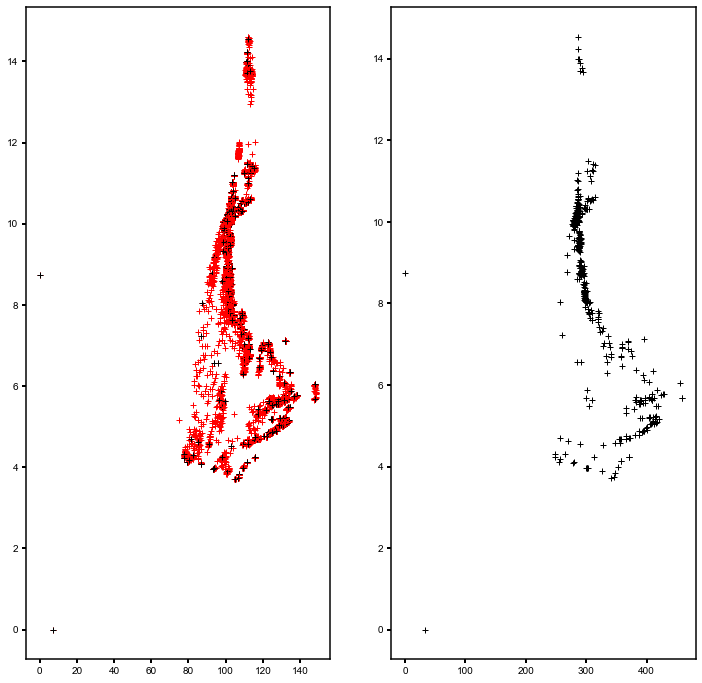

In [70]:
fig, ax = plt.subplots(1,2,figsize=(12, 12))
mld = pd.DataFrame(columns=['MixedLayerDepth','DateTime'])
temp_mld = 0
for i,cast in enumerate(dfsg.groups):
    if dfsg.get_group(cast)['depth (m)'].std() > 1:
        temp_mld = dfsg.get_group(cast)['depth (m)'][(dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth (m)'].diff()).idxmin()]
        mld = mld.append({'MixedLayerDepth':temp_mld,
                   'DateTime': (dfsg.get_group(cast)['Temperature'].diff() / dfsg.get_group(cast)['depth (m)'].diff()).idxmin()},
                   ignore_index=True)
    if (dfsg.get_group(cast)['depth (m)'].std() < 1) and (dfsg.get_group(cast)['depth (m)'].median() < temp_mld) and (temp_mld > 15):
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat (percent)'],dfsg.get_group(cast)['Temperature'],'r+')
        cs = ax[0].plot(dfsg.get_group(cast)['Oxy_Sat (percent)'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        cs = ax[1].plot(dfsg.get_group(cast)['Oxy_Conc'].last('s'),dfsg.get_group(cast)['Temperature'].last('s'),'k+')
        


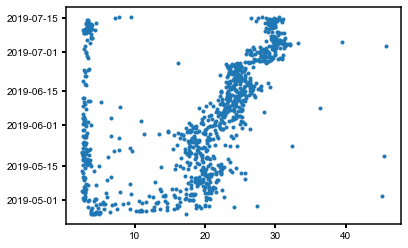

In [68]:
plt.plot(mld.DateTime,mld.MixedLayerDepth,'.')

In [66]:
temp_mld

Timestamp('2019-04-24 23:37:29+0000', tz='UTC')